# Overview

The Titanic Kaggle Competition dataset is a popular dataset used for data analysis and machine learning projects. The dataset contains information about passengers aboard the Titanic, including their age, gender, ticket class, and whether they survived the sinking of the ship or not.

Here's a brief overview of the dataset:

The dataset contains information on 891 passengers on the Titanic, out of a total of 2224 passengers and crew members.

The dataset contains 12 columns:

        PassengerId: Unique identifier for each passenger
        Survived: Whether the passenger survived or not (0 = No, 1 = Yes)
        Pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
        Name: Passenger's name
        Sex: Passenger's sex
        Age: Passenger's age in years
        SibSp: Number of siblings/spouses aboard the Titanic
        Parch: Number of parents/children aboard the Titanic
        Ticket: Ticket number
        Fare: Passenger fare
        Cabin: Cabin number
        Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

# Get the data

Downloading the data from https://homl.info/titanic.tgz and loading the data

In [4]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://homl.info/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/titanic/train.csv"))

titanic = load_titanic_data()

# Take a Quick Look at the Data Structure

In [5]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The second colum contains our labels aka target values.

In [7]:
titanic["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

We notice that 65% of the passengers are males VS only 35% female. We will take this into account later by separating a stratified test set.

We might discard PassengerId, Name and Ticket information, since we doubt it will be helpful.

In [8]:
titanic["Cabin"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

The "Cabin" input feature might need a little more thought to determine if it will serves as well in order to infer our predictions. One option would be to replace this category with a binary encoder (1 = cabin booked / known and 0 = cabin not booked or unknown). Another option would be using only the first letter of the cabin and using a categorical encoder. To get a first prototype relatively fast up and running we might choose to ignore this column at first.

In [9]:
titanic["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

The two missing values at colum "Embarked" will be replaced with the most common class (namely the S class).

In [10]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There are over two hundred missing values for the category "Age". During the preprocessing step we will be replacing the missing values with the median of the dataset.

Now we will be dropping the columns "PassengerID", "Name", "Ticket" and "Cabin".

In [11]:
titanic_preprocessed = titanic.drop(columns=['PassengerId','Name','Ticket', 'Cabin'])

titanic_preprocessed.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


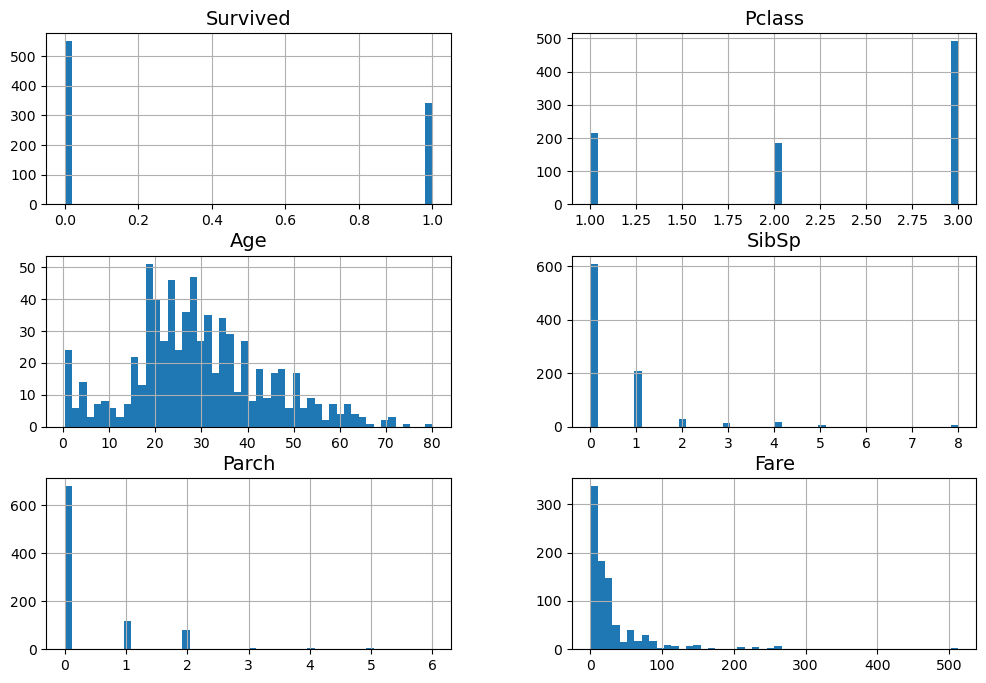

In [12]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

titanic_preprocessed.hist(bins=50, figsize=(12, 8))
#save_fig("attribute_histogram_plots")  # extra code
plt.show()

The features age, SibSp, Parch and Fare are all skewed right. They extend much farther to the right of the median than to the left. This might cause some machine learning algorithms to have trouble detecting patterns. Later we will transform these attributes to have more symmetrical and bell-shaped distributions.

# Create a Test Set

Before we dig deeper into the data now it is a good time to separate the labels an create a test set. Since there is a gender imbalance we choose to create a stratified split and separate 20% of the data with the same gender percentages.

In [13]:
import sklearn
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(
    titanic_preprocessed, test_size=0.2, stratify=titanic_preprocessed["Sex"], random_state=42)

In [14]:
strat_test_set["Sex"].value_counts()

male      116
female     63
Name: Sex, dtype: int64

In [15]:
strat_train_set["Sex"].value_counts()

male      461
female    251
Name: Sex, dtype: int64

As we can observe the gender ratio in both train and test sets are kept by using the stratified split.

# Explore and visualize the data to get insights

In [16]:
titanic = strat_train_set

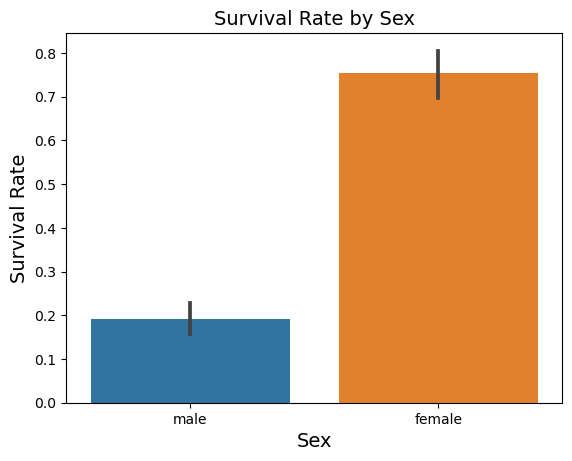

In [17]:
import seaborn as sns

# Plot a bar chart of passenger survival by sex
sns.barplot(data=titanic, x='Sex', y='Survived')
plt.title('Survival Rate by Sex')
plt.xlabel('Sex')
plt.ylabel('Survival Rate')
plt.show()

As we can observe the gender has a big impact in the survival rate.

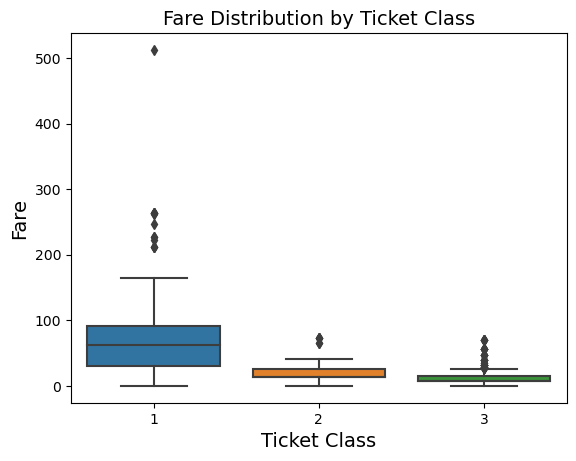

In [19]:
# Plot a boxplot of passenger fares by ticket class
sns.boxplot(data=titanic, x='Pclass', y='Fare')
plt.title('Fare Distribution by Ticket Class')
plt.xlabel('Ticket Class')
plt.ylabel('Fare')
plt.show()

As expected ticket class and passenger fare are fairly closely correlated with some outliers.

Lets create new age categories and plot the survival rate per age category.
0 - 15 Babys, toddlers and small kids
8 - 15 kids and teens
16 - 30 early adult
31- 60 adult
61+ senile

In [46]:
import numpy as np

titanic["age_cat"] = pd.cut(titanic["Age"],
                           bins=[0, 7.5, 15.5, 30.5, 60.5, np.inf],
                           labels = [1, 2, 3, 4, 5])

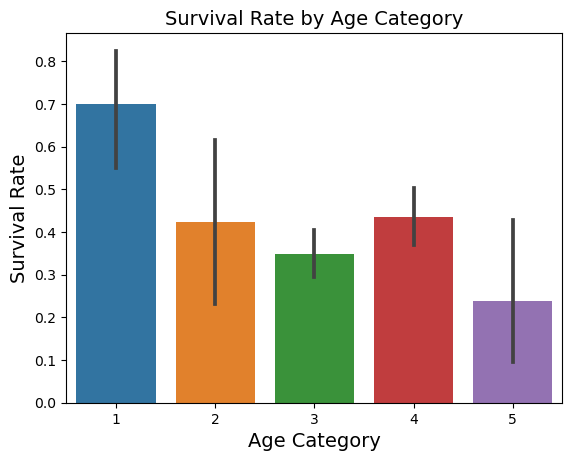

In [47]:
# Plot a bar chart of passenger survival by age category
sns.barplot(data=titanic, x='age_cat', y='Survived')
plt.title('Survival Rate by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Survival Rate')
plt.show()

From plotting the survival rate by age categories we do see a correlation. It seems infants and toddlers do have a higher survival rate while the very old do show a decrease of the survival rate compared to other adults.

# Looking for correlations 

In [48]:
corr_matrix = titanic.corr()

In [51]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.248255
Parch       0.059276
SibSp      -0.045019
Age        -0.075542
Pclass     -0.314577
Name: Survived, dtype: float64

It seems especially the passenger fare and ticket class show the strongest correlation with the survival rate.

Let's try to experiment with a new feature family which is the sum out of 'SibSp' and 'Parch' and look again at the correlations:

In [55]:
titanic["family"] = titanic["SibSp"] + titanic["Parch"]

In [56]:
corr_matrix = titanic.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.248255
Parch       0.059276
family     -0.001468
SibSp      -0.045019
Age        -0.075542
Pclass     -0.314577
Name: Survived, dtype: float64

It does not seem like it will improve correlation with the Survived target category, hence we can drop it.

In [59]:
titanic.drop(['family'], axis=1, inplace=True)

In [60]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,age_cat
788,1,3,male,1.0,1,2,20.5750,S,1
347,1,3,female,NaN,1,0,16.1000,S,NaN
629,0,3,male,NaN,0,0,7.7333,Q,NaN
734,0,2,male,23.0,0,0,13.0000,S,3
106,1,3,female,21.0,0,0,7.6500,S,3


# Prepare the Data for Machine Learning Algorithms